In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import xlrd

In [2]:
xlsx = pd.ExcelFile('KPMG_VI_New_raw_data_update_final.xlsx')
transactions = pd.read_excel(xlsx, 'Transactions', header=[1])
new_customers = pd.read_excel(xlsx, 'NewCustomerList', header=[1])
demographics = pd.read_excel(xlsx, 'CustomerDemographic', header=[1])
address = pd.read_excel(xlsx, 'CustomerAddress', header=[1])

Our goal for this task is to reformat the data based on our quality assessment in the last notebook. We won't impute the missing data for now as we still need to explore the data further for any relationships that we might miss.

# TRANSACTIONS

We need to transform product_first_sold_date into a datetime type. First, we need to transform product_first_sold_date to an integer so that we can turn this into a datetime date type. Because we can't ignore null values when transforming an ordinal number to a datetime, we will have to iterate through

In [3]:
transactions.product_first_sold_date = transactions.product_first_sold_date.astype('Int64')

In [4]:
product_first_sold_date_dt = []

for i in transactions.product_first_sold_date.index:
    if type(transactions.product_first_sold_date[i]) == np.int64:
        new_dt = xlrd.xldate_as_datetime(transactions.product_first_sold_date[i], 0)
        product_first_sold_date_dt.append(new_dt)
    else:
        product_first_sold_date_dt.append(transactions.product_first_sold_date[i])
        
transactions['product_first_sold_date'] = product_first_sold_date_dt

In [5]:
# check if features are unique for id and transaction dates
features = transactions.iloc[:,:]

for i in features.columns:
    print(f'unique {i}: {len(features[i].unique())}')

unique transaction_id: 20000
unique product_id: 101
unique customer_id: 3494
unique transaction_date: 364
unique online_order: 3
unique order_status: 2
unique brand: 7
unique product_line: 5
unique product_class: 4
unique product_size: 4
unique list_price: 296
unique standard_cost: 104
unique product_first_sold_date: 101


There do not seem to be any duplicate transaction ids. All other columns are okay and within range.

In [6]:
# check for missing values and count total values
features = transactions.iloc[:,4:]

for i in features.columns:
    print(f'missing in {i}: {features[i].isna().sum()}')
    print(f'{features[i].value_counts()}\n')

missing in online_order: 360
1.0    9829
0.0    9811
Name: online_order, dtype: int64

missing in order_status: 0
Approved     19821
Cancelled      179
Name: order_status, dtype: int64

missing in brand: 197
Solex             4253
Giant Bicycles    3312
WeareA2B          3295
OHM Cycles        3043
Trek Bicycles     2990
Norco Bicycles    2910
Name: brand, dtype: int64

missing in product_line: 197
Standard    14176
Road         3970
Touring      1234
Mountain      423
Name: product_line, dtype: int64

missing in product_class: 197
medium    13826
high       3013
low        2964
Name: product_class, dtype: int64

missing in product_size: 197
medium    12990
large      3976
small      2837
Name: product_size, dtype: int64

missing in list_price: 0
2091.47    465
1403.50    396
71.49      274
1231.15    235
1890.39    233
          ... 
489.58       1
1348.41      1
883.91       1
1220.66      1
1142.89      1
Name: list_price, Length: 296, dtype: int64

missing in standard_cost: 197
388

There are missing features, but these are all formatted correctly with unique variables. Let's check to see how many cancelled orders also have missing values in product line, class, size, cost, and brand. We can see that we have a list price and standard cost, but no column for profits. Let's create this now.

In [7]:
missing_transactions = transactions.loc[transactions.product_line.isna() & transactions.brand.isna() & transactions.product_class.isna() 
                 & transactions.product_size.isna() & transactions.standard_cost.isna() & 
                 transactions.product_first_sold_date.isna(), :]
missing_transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197 entries, 136 to 19871
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   transaction_id           197 non-null    int64         
 1   product_id               197 non-null    int64         
 2   customer_id              197 non-null    int64         
 3   transaction_date         197 non-null    datetime64[ns]
 4   online_order             195 non-null    float64       
 5   order_status             197 non-null    object        
 6   brand                    0 non-null      object        
 7   product_line             0 non-null      object        
 8   product_class            0 non-null      object        
 9   product_size             0 non-null      object        
 10  list_price               197 non-null    float64       
 11  standard_cost            0 non-null      float64       
 12  product_first_sold_date  0 non-n

In [8]:
transactions['profit'] = round(transactions.list_price - transactions.standard_cost, 2)

#### REFORMAT ORDER STATUS

Change order status to a binary value

In [9]:
transactions.loc[transactions.order_status == 'Approved', 'order_status'] = 1
transactions.loc[transactions.order_status == 'Cancelled', 'order_status'] = 0

We can see that while we don't have any product data for 197 of transactions tracker, all order statuses were approved. Sprocket is concerned about which customers to target based on their demographics so these transactions may still provide valuable insight about them. 

# CURRENT CUSTOMERS

In [10]:
demographics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   customer_id                          4000 non-null   int64         
 1   first_name                           4000 non-null   object        
 2   last_name                            3875 non-null   object        
 3   gender                               4000 non-null   object        
 4   past_3_years_bike_related_purchases  4000 non-null   int64         
 5   DOB                                  3913 non-null   datetime64[ns]
 6   job_title                            3494 non-null   object        
 7   job_industry_category                3344 non-null   object        
 8   wealth_segment                       4000 non-null   object        
 9   deceased_indicator                   4000 non-null   object        
 10  default     

In [11]:
demographics.head().T

,0,1,2,3,4
customer_id,1,2,3,4,5
first_name,Laraine,Eli,Arlin,Talbot,Sheila-kathryn
last_name,Medendorp,Bockman,Dearle,NaN,Calton
gender,F,Male,Male,Male,Female
past_3_years_bike_related_purchases,93,81,61,33,56
DOB,1953-10-12 00:00:00,1980-12-16 00:00:00,1954-01-20 00:00:00,1961-10-03 00:00:00,1977-05-13 00:00:00
job_title,Executive Secretary,Administrative Officer,Recruiting Manager,NaN,Senior Editor
job_industry_category,Health,Financial Services,Property,IT,NaN
wealth_segment,Mass Customer,Mass Customer,Mass Customer,Mass Customer,Affluent Customer
deceased_indicator,N,N,N,N,N


Immediately we can see that default is an irrelevant column and can be dropped, reformat the gender column to a consistent naming convention, and ensure that all date of births are within a reasonable range and makes sense with the rest of the data.

In [12]:
# drop default
demographics.drop('default', axis=1, inplace=True)

In [13]:
print(f'Earliest DOB: {min(demographics.DOB)}')
print(f'Latest DOB: {max(demographics.DOB)}')

Earliest DOB: 1843-12-21 00:00:00
Latest DOB: 2002-03-11 00:00:00


In [14]:
# drop the column with Year of Birth, 1843
demographics[demographics.DOB == datetime.datetime(1843, 12, 21, 0, 0)]

demographics.drop(33, axis=0, inplace=True)
demographics.reset_index(drop=True, inplace=True)

In [15]:
# check that all birth dates are adjusted
print(f'Earliest DOB: {min(demographics.DOB)}')
print(f'Latest DOB: {max(demographics.DOB)}')

Earliest DOB: 1931-10-23 00:00:00
Latest DOB: 2002-03-11 00:00:00


In [16]:
# check all customers have a unique customer id
features = demographics.iloc[:,0]
print(f'unique customer_id: {len(features.unique())}')

unique customer_id: 3999


In [17]:
# look at range of customer ids
demographics.customer_id.unique()

array([   1,    2,    3, ..., 3998, 3999, 4000], dtype=int64)

In [18]:
cat_features = demographics.iloc[:,[3, 6, 7, 8, 9, 11]]
for i in cat_features.columns:
    print(f'missing/is null {i}: {cat_features[i].isna().sum()}')
    print(f'{cat_features[i].value_counts()}\n')

missing/is null gender: 0
Female    2037
Male      1872
U           87
M            1
Femal        1
F            1
Name: gender, dtype: int64

missing/is null job_title: 506
Business Systems Development Analyst    45
Tax Accountant                          44
Social Worker                           44
Internal Auditor                        42
Recruiting Manager                      41
                                        ..
Staff Accountant I                       4
Health Coach III                         3
Research Assistant III                   3
Health Coach I                           3
Developer I                              1
Name: job_title, Length: 195, dtype: int64

missing/is null job_industry_category: 656
Manufacturing         799
Financial Services    774
Health                602
Retail                358
Property              267
IT                    222
Entertainment         136
Argiculture           113
Telecommunications     72
Name: job_industry_category, dt

### REFORMATTING

#### GENDER

In [19]:
# reformat gender
demographics.loc[demographics.gender == 'F', 'gender'] = 'Female'
demographics.loc[demographics.gender == 'Femal', 'gender'] = 'Female'
demographics.loc[demographics.gender == 'M', 'gender'] = 'Male'

In [20]:
demographics.gender.unique()

array(['Female', 'Male', 'U'], dtype=object)

#### deceased_indicator and owns_car

Let's convert these to binary values

In [21]:
demographics.loc[demographics.deceased_indicator == 'Y', 'deceased_indicator'] = 1
demographics.loc[demographics.deceased_indicator == 'N', 'deceased_indicator'] = 0

In [22]:
demographics.loc[demographics.owns_car == 'Yes', 'owns_car'] = 1
demographics.loc[demographics.owns_car == 'No', 'owns_car'] = 0

#### JOB TITLE

In [23]:
job_titles = demographics.job_title.unique()
# change nan to a str
job_titles[3] = 'NA'
#sort alphabetically
sorted(job_titles)

['Account Coordinator',
 'Account Executive',
 'Account Representative I',
 'Account Representative II',
 'Account Representative III',
 'Account Representative IV',
 'Accountant I',
 'Accountant II',
 'Accountant III',
 'Accountant IV',
 'Accounting Assistant I',
 'Accounting Assistant II',
 'Accounting Assistant III',
 'Accounting Assistant IV',
 'Actuary',
 'Administrative Assistant I',
 'Administrative Assistant II',
 'Administrative Assistant III',
 'Administrative Assistant IV',
 'Administrative Officer',
 'Analog Circuit Design manager',
 'Analyst Programmer',
 'Assistant Manager',
 'Assistant Media Planner',
 'Assistant Professor',
 'Associate Professor',
 'Automation Specialist I',
 'Automation Specialist II',
 'Automation Specialist III',
 'Automation Specialist IV',
 'Biostatistician I',
 'Biostatistician II',
 'Biostatistician III',
 'Biostatistician IV',
 'Budget/Accounting Analyst I',
 'Budget/Accounting Analyst II',
 'Budget/Accounting Analyst III',
 'Budget/Accounting A

We can see that some job titles have different levels. Let's try grouping these without them and reduce the number of categorical variables.

In [24]:
# strip levels and trailing characters
demographics['job_title'] = demographics.job_title.str.rstrip('I{1,3}V?').str.rstrip()

#### AGE

Let's add a column for age instead of DOB. We can then drop DOB.

In [25]:
#find the age of each customer at time of purchase
#initialize a column in demographics called 'age'
demographics['age'] = np.nan

for i in demographics.index:
    age = 2017 - demographics.DOB[i].year
    demographics.loc[i, 'age'] = age

#change dtype to int
demographics.age = demographics.age.astype('Int64')

In [26]:
# drop DOB
demographics.drop('DOB', axis=1, inplace=True)

### BINNING

#### TENURE

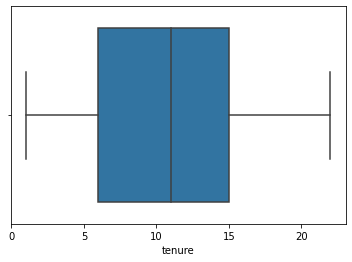

In [27]:
sns.boxplot(data=demographics, x='tenure')
plt.show()

Let's simplify tenure, by binning the values. Based on the IQR range, we can break up the data in increments of 5 years. This will not affect the missing data.

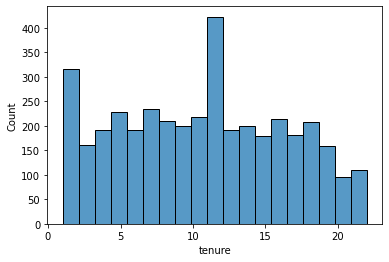

In [28]:
sns.histplot(data=demographics, x='tenure')
plt.show()

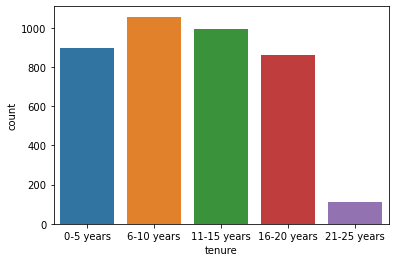

In [29]:
# create bins and labels
bins = [0, 5, 10, 15, 20, 25]
labels = ['0-5 years','6-10 years','11-15 years','16-20 years','21-25 years']
#bin data
demographics['tenure'] = pd.cut(demographics['tenure'] , bins=bins, labels=labels, include_lowest=True)

sns.countplot(data = demographics, x='tenure')
plt.show()

#### AGE

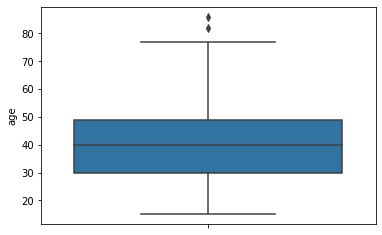

In [30]:
sns.boxplot(data=demographics, y='age')
plt.show()

In [31]:
# create bins and labels for increments of 10 years
bins = [0, 20, 30, 40, 50, 60, 70, 90]
labels = ['20 and younger','21-30 years old','31-40 years old','41-50 years old','51-60 years old',
          '61-70 years old','70 and up']
# bin data
demographics['age'] = pd.cut(demographics['age'] , bins=bins, labels=labels, include_lowest=True)

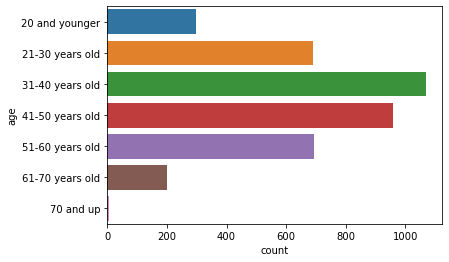

In [32]:
sns.countplot(data=demographics, y='age')
plt.show()

# ADDRESS

In [33]:
address.head()

,customer_id,address,postcode,state,country,property_valuation
0,1,060 Morning Avenue,2016,New South Wales,Australia,10
1,2,6 Meadow Vale Court,2153,New South Wales,Australia,10
2,4,0 Holy Cross Court,4211,QLD,Australia,9
3,5,17979 Del Mar Point,2448,New South Wales,Australia,4
4,6,9 Oakridge Court,3216,VIC,Australia,9


In [34]:
address.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   customer_id         3999 non-null   int64 
 1   address             3999 non-null   object
 2   postcode            3999 non-null   int64 
 3   state               3999 non-null   object
 4   country             3999 non-null   object
 5   property_valuation  3999 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 187.6+ KB


Because there are so many unique postcodes, let's group these based on levels of remoteness. According to the Australian Bureau of Statistics, levels of remoteness are defined as the following:

- Major Cities of Australia
- Inner Regional Australia
- Outer Regional Australia
- Remote Australia
- Very Remote Australia

Remoteness is calculated using the Accessibility and Remoteness Index of Australia (ARIA+). ARIA+ is derived by measuring the road distance from a point to the nearest Urban Centres and Localities in five separate population ranges. For more information, please read about Defining Remote Areas on the ABS website [here](https://www.abs.gov.au/ausstats/abs@.nsf/Latestproducts/1270.0.55.005Main%20Features15July%202016?opendocument&tabname=Summary&prodno=1270.0.55.005&issue=July%202016&num=&view=).

We will need to download the 2017 Postcode to 2016 Remoteness Census Area Conversion.

### GROUP BY REMOTENESS INDEX

In [35]:
# read in the ABS file
xlsx = pd.ExcelFile('ABS_postcode_2017_ra_2016\CG_POSTCODE_2017_RA_2016.xlsx')
remoteness = pd.read_excel(xlsx, 'Table 3', header=[5])

In [36]:
remoteness.head()

,POSTCODE_2017,POSTCODE_2017.1,RA_CODE_2016,RA_NAME_2016,RATIO,PERCENTAGE
0,NaN,NaN,NaN,NaN,NaN,NaN
1,0800,800.0,72.0,Outer Regional Australia,1.0,100.0
2,0810,810.0,72.0,Outer Regional Australia,1.0,100.0
3,0812,812.0,72.0,Outer Regional Australia,1.0,100.0
4,0815,815.0,72.0,Outer Regional Australia,1.0,100.0


In [37]:
remoteness.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54854 entries, 0 to 54853
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   POSTCODE_2017    3182 non-null   object 
 1   POSTCODE_2017.1  3181 non-null   float64
 2   RA_CODE_2016     3181 non-null   float64
 3   RA_NAME_2016     3181 non-null   object 
 4   RATIO            3181 non-null   float64
 5   PERCENTAGE       3181 non-null   float64
dtypes: float64(4), object(2)
memory usage: 2.5+ MB


In [38]:
# drop the NaN value
remoteness.drop(0, axis=0, inplace=True)
remoteness.reset_index(drop=True, inplace=True)

In [39]:
remoteness.head()

,POSTCODE_2017,POSTCODE_2017.1,RA_CODE_2016,RA_NAME_2016,RATIO,PERCENTAGE
0,0800,800.0,72.0,Outer Regional Australia,1.0,100.0
1,0810,810.0,72.0,Outer Regional Australia,1.0,100.0
2,0812,812.0,72.0,Outer Regional Australia,1.0,100.0
3,0815,815.0,72.0,Outer Regional Australia,1.0,100.0
4,0820,820.0,72.0,Outer Regional Australia,1.0,100.0


In [40]:
remoteness.tail()

,POSTCODE_2017,POSTCODE_2017.1,RA_CODE_2016,RA_NAME_2016,RATIO,PERCENTAGE
54848,NaN,NaN,NaN,NaN,NaN,NaN
54849,NaN,NaN,NaN,NaN,NaN,NaN
54850,NaN,NaN,NaN,NaN,NaN,NaN
54851,NaN,NaN,NaN,NaN,NaN,NaN
54852,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
#drop row 2671 and 2672
remoteness.drop([2671, 2672], axis=0, inplace=True)

In [42]:
with pd.ExcelWriter('ABS_postcode_2017_ra_2016\CG_POSTCODE_2017_RA_2016_clean.xlsx') as writer:  
    remoteness.to_excel(writer, sheet_name='Table 3', index=False)

In [43]:
# drop the duplicate postcode, the RA code, and ratio as this is just a duplicate of percentage
remoteness.drop(['POSTCODE_2017.1', 'RA_CODE_2016', 'RATIO'], axis=1, inplace=True)

In [44]:
# check if there are duplicate postcodes
remoteness.POSTCODE_2017.value_counts()

2611    4
4741    4
0872    4
2620    4
2652    3
       ..
4713    1
4712    1
4711    1
4710    1
0874    1
Name: POSTCODE_2017, Length: 2670, dtype: int64

In [45]:
remoteness[remoteness.POSTCODE_2017 == 4741]

,POSTCODE_2017,RA_NAME_2016,PERCENTAGE
2091,4741,Inner Regional Australia,7.213018
2092,4741,Outer Regional Australia,90.592145
2093,4741,Remote Australia,2.109869
2094,4741,Very Remote Australia,0.084968


We can see that there are duplicate postcodes with varying degrees of remoteness due to the large area postcode covers. For simplicity, we will narrow this down to one remoteness area with the highest percentage or ratio that postcode covers. In this case, 90% of postcode 4741 is in Outer Regional Australia.

In [46]:
# drop duplicates
remoteness = remoteness.sort_values('PERCENTAGE').drop_duplicates('POSTCODE_2017', keep='last').reset_index(drop=True)
remoteness[remoteness.POSTCODE_2017 == 4741]

,POSTCODE_2017,RA_NAME_2016,PERCENTAGE
231,4741,Outer Regional Australia,90.592145


In [47]:
# rename columns
remoteness.rename(columns={'POSTCODE_2017': 'postcode', 'RA_NAME_2016': 'region', 'PERCENTAGE':'percentage'}, inplace=True)

In [48]:
# we don't need the percentage anymore so we can drop this as well
remoteness.drop('percentage', axis=1, inplace=True)

In [49]:
remoteness.head()

,postcode,region
0,4184,Outer Regional Australia
1,2484,Inner Regional Australia
2,7150,Inner Regional Australia
3,4520,Inner Regional Australia
4,2804,Inner Regional Australia


Now, we need to merge on the postcodes in address and remoteness.

### MERGE REMOTE INDEX WITH ADDRESS

In [50]:
address = address.merge(remoteness, how='left', on='postcode')

In [51]:
address.head()

,customer_id,address,postcode,state,country,property_valuation,region
0,1,060 Morning Avenue,2016,New South Wales,Australia,10,Major Cities of Australia
1,2,6 Meadow Vale Court,2153,New South Wales,Australia,10,Major Cities of Australia
2,4,0 Holy Cross Court,4211,QLD,Australia,9,Major Cities of Australia
3,5,17979 Del Mar Point,2448,New South Wales,Australia,4,Outer Regional Australia
4,6,9 Oakridge Court,3216,VIC,Australia,9,Major Cities of Australia


In [52]:
features = address.iloc[:,:]
for i in features.columns:
    print(f'missing/is null {i}: {features[i].isna().sum()}')
    print(f'{features[i].value_counts()}\n')

missing/is null customer_id: 0
2047    1
653     1
2728    1
677     1
2724    1
       ..
3371    1
1322    1
3367    1
1318    1
2049    1
Name: customer_id, Length: 3999, dtype: int64

missing/is null address: 0
3 Mariners Cove Terrace    2
3 Talisman Place           2
64 Macpherson Junction     2
583 Eagle Crest Road       1
18652 Springs Plaza        1
                          ..
2 Hoffman Way              1
1 Cordelia Alley           1
567 Scott Park             1
29419 Harper Circle        1
38 Trailsway Parkway       1
Name: address, Length: 3996, dtype: int64

missing/is null postcode: 0
2170    31
2145    30
2155    30
2153    29
2560    26
        ..
2469     1
4155     1
2474     1
3093     1
3094     1
Name: postcode, Length: 873, dtype: int64

missing/is null state: 0
NSW                2054
VIC                 939
QLD                 838
New South Wales      86
Victoria             82
Name: state, dtype: int64

missing/is null country: 0
Australia    3999
Name: country,

We can see that there are no missing values. We only need to reformat the state names.

In [53]:
address.loc[address.state == 'New South Wales', 'state'] = 'NSW'
address.loc[address.state == 'Victoria', 'state'] = 'VIC'

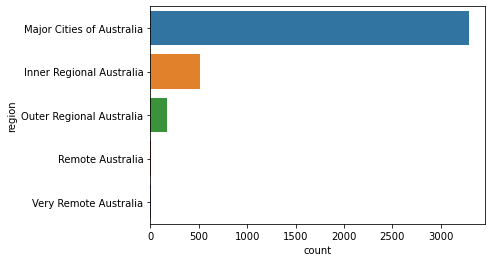

In [54]:
sns.countplot(data=address, y='region', order=address.region.value_counts().index)
plt.show()

# NEW CUSTOMERS

In [55]:
new_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 23 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   first_name                           1000 non-null   object        
 1   last_name                            971 non-null    object        
 2   gender                               1000 non-null   object        
 3   past_3_years_bike_related_purchases  1000 non-null   int64         
 4   DOB                                  983 non-null    datetime64[ns]
 5   job_title                            894 non-null    object        
 6   job_industry_category                835 non-null    object        
 7   wealth_segment                       1000 non-null   object        
 8   deceased_indicator                   1000 non-null   object        
 9   owns_car                             1000 non-null   object        
 10  tenure       

Right away we can immediately dropped the unnamed columns as this won't be relevant to our analysis. We can generalize our data to age and tenure ranges.

In [56]:
new_customers.drop(['Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20'], axis=1, inplace=True)

In [57]:
# check all DOBs are okay
print(f'Earliest DOB: {min(new_customers.DOB)}')
print(f'Latest DOB: {max(new_customers.DOB)}')

Earliest DOB: 1938-06-08 00:00:00
Latest DOB: 2002-02-27 00:00:00


In [58]:
features = new_customers.iloc[:,:]

for i in features.columns:
    print(f'missing/is null {i}: {features[i].isna().sum()}')
    print(f'{features[i].value_counts()}\n')

missing/is null first_name: 0
Mandie       3
Rozamond     3
Dorian       3
Dmitri       2
Anthony      2
            ..
My           1
Sherilyn     1
Mel          1
Rosalinde    1
Dyann        1
Name: first_name, Length: 940, dtype: int64

missing/is null last_name: 29
Sturch           2
Minshall         2
Van den Velde    2
Borsi            2
Crellim          2
                ..
Beccero          1
Iltchev          1
Harniman         1
Friese           1
Siemantel        1
Name: last_name, Length: 961, dtype: int64

missing/is null gender: 0
Female    513
Male      470
U          17
Name: gender, dtype: int64

missing/is null past_3_years_bike_related_purchases: 0
60    20
59    18
70    17
42    17
37    16
      ..
19     5
9      5
92     5
85     4
20     3
Name: past_3_years_bike_related_purchases, Length: 100, dtype: int64

missing/is null DOB: 17
1961-07-31    2
1994-04-15    2
1987-01-15    2
1951-11-28    2
1979-07-28    2
             ..
1947-04-21    1
1995-10-10    1
1964-

### REFORMATTING

In [59]:
new_customers.job_title.head(10)

0                 General Manager
1             Structural Engineer
2          Senior Cost Accountant
3      Account Representative III
4               Financial Analyst
5         Assistant Media Planner
6            Compensation Analyst
7    Human Resources Assistant II
8              Speech Pathologist
9         Accounting Assistant IV
Name: job_title, dtype: object

In [60]:
# strip levels and trailing characters
new_customers['job_title'] = new_customers.job_title.str.rstrip('I{1,3}V?').str.rstrip()

In [61]:
new_customers.job_title.unique()

array(['General Manager', 'Structural Engineer', 'Senior Cost Accountant',
       'Account Representative', 'Financial Analyst',
       'Assistant Media Planner', 'Compensation Analyst',
       'Human Resources Assistant', 'Speech Pathologist',
       'Accounting Assistant', 'Programmer Analyst',
       'Environmental Specialist', 'Human Resources Manager',
       'VP Marketing', 'Clinical Specialist', nan, 'Associate Professor',
       'Actuary', 'Internal Auditor', 'Programmer', 'Quality Engineer',
       'Quality Control Specialist', 'Account Executive', 'Engineer',
       'Nurse', 'Librarian', 'Paralegal', 'Assistant Manager',
       'Senior Quality Engineer', 'Recruiting Manager', 'Design Engineer',
       'Business Systems Development Analyst', 'VP Quality Control',
       'Cost Accountant', 'Product Engineer', 'Social Worker',
       'Payment Adjustment Coordinator', 'Marketing Assistant',
       'Recruiter', 'VP Product Management', 'Media Manager', 'Developer',
       'Senior 

#### TENURE

We will also bin tenure for new customers with the same intervals.

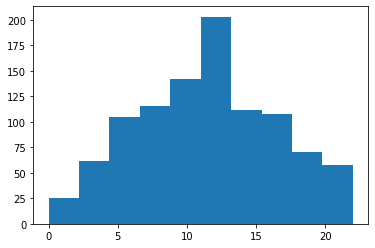

In [62]:
plt.hist(new_customers.tenure)
plt.show()

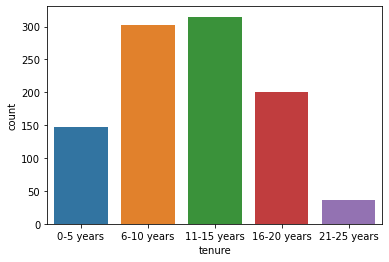

In [63]:
# create bins and labels
bins = [0, 5, 10, 15, 20, 25]
labels = ['0-5 years','6-10 years','11-15 years','16-20 years','21-25 years']
#bin data
new_customers['tenure'] = pd.cut(new_customers['tenure'] , bins=bins, labels=labels, include_lowest=True)

sns.countplot(data = new_customers, x='tenure')
plt.show()

#### AGE

We can bin age once more for the new customers.

In [64]:
#find the age of each customer at time of purchase
#initialize a column called 'age'
new_customers['age'] = np.nan

for i in new_customers.index:
    age = 2017 - new_customers.DOB[i].year
    new_customers.loc[i, 'age'] = age

#change dtype to int
new_customers.age = new_customers.age.astype('Int64')

# create bins and labels for increments of 10 years
bins = [0, 20, 30, 40, 50, 60, 70, 90]
labels = ['20 and younger','21-30 years old','31-40 years old','41-50 years old','51-60 years old',
          '61-70 years old','70 and up']
#bin data
new_customers['age'] = pd.cut(new_customers['age'] , bins=bins, labels=labels, include_lowest=True)

Because we do not have columns for Rank and Value for existing customers, we won't know how to predict based on these features. We can drop these columns from our dataset. However,  we will save this as a new dataframe in case we discover a use for these features as we continue to explore the data. We will also need to merge this with the remoteness index to get an idea of what region these customers are from. 

In [65]:
new_customers1 = new_customers.drop(['Rank', 'Value', 'DOB'], axis=1)

In [66]:
# merge remoteness
new_customers1 = new_customers1.merge(remoteness, how='left', on='postcode')

In [67]:
new_customers1.head().T

,0,1,2,3,4
first_name,Chickie,Morly,Ardelis,Lucine,Melinda
last_name,Brister,Genery,Forrester,Stutt,Hadlee
gender,Male,Male,Female,Female,Female
past_3_years_bike_related_purchases,86,69,10,64,34
job_title,General Manager,Structural Engineer,Senior Cost Accountant,Account Representative,Financial Analyst
job_industry_category,Manufacturing,Property,Financial Services,Manufacturing,Financial Services
wealth_segment,Mass Customer,Mass Customer,Affluent Customer,Affluent Customer,Affluent Customer
deceased_indicator,N,N,N,N,N
owns_car,Yes,No,No,Yes,No
tenure,11-15 years,16-20 years,6-10 years,0-5 years,16-20 years


# MERGING THE TABLES

Before we can explore the data, we need to merge the tables and make sure that there aren't any more reformatting issues, duplicates, or missing values. 

First, we will join the existing customers to their addresses then transactions.

In [68]:
# merge existing customers to their addresses
df = demographics.merge(address, how='outer', on='customer_id')

In [69]:
# merge transactions with df to get a better picture of the data
df = df.merge(transactions, how='outer', on='customer_id')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20510 entries, 0 to 20509
Data columns (total 31 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   customer_id                          20510 non-null  int64         
 1   first_name                           20495 non-null  object        
 2   last_name                            19840 non-null  object        
 3   gender                               20495 non-null  object        
 4   past_3_years_bike_related_purchases  20495 non-null  float64       
 5   job_title                            18018 non-null  object        
 6   job_industry_category                17171 non-null  object        
 7   wealth_segment                       20495 non-null  object        
 8   deceased_indicator                   20495 non-null  object        
 9   owns_car                             20495 non-null  object        
 10  tenure    

In [70]:
# check if features are unique
features = df.iloc[:,:]

for i in features.columns:
    print(f'unique {i}: {len(features[i].unique())}')

unique customer_id: 4004
unique first_name: 3139
unique last_name: 3725
unique gender: 4
unique past_3_years_bike_related_purchases: 101
unique job_title: 115
unique job_industry_category: 10
unique wealth_segment: 4
unique deceased_indicator: 3
unique owns_car: 3
unique tenure: 6
unique age: 8
unique address: 3997
unique postcode: 874
unique state: 4
unique country: 2
unique property_valuation: 13
unique region: 6
unique transaction_id: 20001
unique product_id: 102
unique transaction_date: 365
unique online_order: 3
unique order_status: 3
unique brand: 7
unique product_line: 5
unique product_class: 4
unique product_size: 4
unique list_price: 297
unique standard_cost: 104
unique product_first_sold_date: 102
unique profit: 101


In [71]:
# check for missing values and count total values
features = df.iloc[:,:]

for i in features.columns:
    print(f'missing in {i}: {features[i].isna().sum()}')
    print(f'{features[i].value_counts()}\n')

missing in customer_id: 0
2183    14
1068    14
2476    14
1302    13
1946    13
        ..
3661     1
3568     1
3552     1
3645     1
3733     1
Name: customer_id, Length: 4004, dtype: int64

missing in first_name: 15
Corabelle    36
Tobe         31
Emlyn        29
Lindsay      28
Gar          26
             ..
Stephen       1
Kristin       1
Yanaton       1
Tadd          1
Thayne        1
Name: first_name, Length: 3138, dtype: int64

missing in last_name: 670
Gladman      24
Fyndon       23
Creebo       18
Leek         18
Elgey        18
             ..
Scamwell      1
Cleaves       1
Dollimore     1
Suddaby       1
Ackhurst      1
Name: last_name, Length: 3724, dtype: int64

missing in gender: 15
Female    10290
Male       9748
U           457
Name: gender, dtype: int64

missing in past_3_years_bike_related_purchases: 15
16.0    297
80.0    276
19.0    264
2.0     262
13.0    261
       ... 
3.0     139
85.0    123
8.0     121
92.0    121
86.0    113
Name: past_3_years_bike_relate

In [75]:
df.tail(10).T

,20485,20486,20487,20488,20489,20490,20491,20492,20493,20494
customer_id,3991,3992,3993,3994,3995,3996,3997,3998,3999,4000
first_name,Rolph,Germain,Andi,Stephie,Rusty,Rosalia,Blanch,Sarene,Patrizius,Kippy
last_name,Sweetnam,Tireman,Dumelow,Byars,Iapico,Halgarth,Nisuis,Woolley,NaN,Oldland
gender,Male,Male,Female,Female,Male,Female,Female,U,Male,Male
past_3_years_bike_related_purchases,61,99,6,5,93,8,87,60,11,76
job_title,Chief Design Engineer,Database Administrator,Librarian,Structural Analysis Engineer,Staff Scientist,VP Product Management,Statistician,Assistant Manager,NaN,Software Engineer
job_industry_category,Manufacturing,Manufacturing,Entertainment,Manufacturing,Manufacturing,Health,Manufacturing,IT,Manufacturing,NaN
wealth_segment,Mass Customer,Affluent Customer,Mass Customer,Affluent Customer,Mass Customer,Mass Customer,High Net Worth,High Net Worth,Affluent Customer,Affluent Customer
deceased_indicator,0,0,0,0,0,0,0,0,0,0
owns_car,1,1,0,0,1,0,1,0,1,0


We can see that there was some missing data from addresses that were not in our existing customer list. However, there don't seem to be any duplicates.

There are approximately 500 customers that do not have any information on purchases they made and 3 customers with no usable features. Since our goal is to determine what features to use in our marketing strategy, we will drop customer ids 4001, 4002, and 4003.

We should be okay to drop these as they make up less than 1% of our dataset.

We don't want to drop the other customers as it is possible they chose not to buy anything at all. That means their features will be useful for determining what market segments _not_ to focus on.

We have a total of 5 existing customers that were not in the customer list (customer_id 34, 4001, 4002, 4003, 5034). Since we are trying to identify a target demographic, 34 and 5034 will not be helpful in helping us narrow down a market segment. We will drop these as well.

In [73]:
# drop customer_id 4001, 4002, 4003, 34, and 5034 from df
drop_id = df[(df.customer_id == 4001) | (df.customer_id == 4002) | (df.customer_id == 4003) | (df.customer_id == 34) | (df.customer_id == 5034)].index
df.drop(drop_id, axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

Now that we have cleaned and reformatted our data, we can now explore any trends or patterns. Let's save a copy of these cleaned datasets along with our cleaned new customer list.

In [74]:
with pd.ExcelWriter('KPMG_clean_data.xlsx') as writer:  
    df.to_excel(writer, sheet_name='TrainingData', index=False)
    demographics.to_excel(writer, sheet_name='ExistingCustomerList', index=False)
    transactions.to_excel(writer, sheet_name='Transactions', index=False)
    new_customers1.to_excel(writer, sheet_name='NewCustomerList', index=False)